In [83]:
import os, sys, math
cwd = os.getcwd()
project_path = cwd[:cwd.find('pygents')+7]
if project_path not in sys.path: sys.path.append(project_path)
os.chdir(project_path)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import datetime as dt

from pygents.aigents_api import tokenize_re
from pygents.util import dictcount
from pygents.aigents_api import build_ngrams

from pygents.aigents_api import TextMetrics

grand_t0 = dt.datetime.now()

def language_metrics(metrics_list):
    metrics = {}
    for m in metrics_list:
        metrics[m] = './data/models/distortions/overfitting_combined/multiclass_view/' + m + '.txt'
    return metrics

In [84]:
binary_dataset_file_path = "./data/corpora/English/distortions/halilbabacan/raw_Cognitive_distortions.csv" 

import kagglehub
multiclass_dataset_path = kagglehub.dataset_download("sagarikashreevastava/cognitive-distortion-detetction-dataset")
multiclass_dataset_file_path = multiclass_dataset_path + "/Annotated_data.csv"

df1 = pd.read_csv(binary_dataset_file_path)
df1 = df1.rename(columns={'Text': 'Patient Question', 'Label': 'Dominant Distortion'})
df1.insert(1, "Distorted part", value = np.nan)
df1.insert(3, "Secondary Distortion (Optional)l", value = np.nan)

df2 = pd.read_csv(multiclass_dataset_file_path) 
df2 = df2.drop('Id_Number', axis=1) # delete columnb with id 

df3 = pd.concat([df1, df2], ignore_index=True)
df3

,Patient Question,Distorted part,Dominant Distortion,Secondary Distortion (Optional)l,Secondary Distortion (Optional)
0,I'm such a failure I never do anything right.,NaN,Distortion,NaN,NaN
1,Nobody likes me because I'm not interesting.,NaN,Distortion,NaN,NaN
2,I can't try new things because I'll just mess...,NaN,Distortion,NaN,NaN
3,My boss didn't say 'good morning' she must be...,NaN,Distortion,NaN,NaN
4,My friend didn't invite me to the party I mus...,NaN,Distortion,NaN,NaN
...,...,...,...,...,...
6052,I’m a 21 year old female. I spent most of my l...,NaN,No Distortion,NaN,NaN
6053,I am 21 female and have not had any friends fo...,Now I am at university my peers around me all ...,Overgeneralization,NaN,NaN
6054,From the U.S.: My brother is 19 years old and ...,He claims he’s severely depressed and has outb...,Mental filter,NaN,Mind Reading
6055,From the U.S.: I am a 21 year old woman who ha...,NaN,No Distortion,NaN,NaN


In [85]:
def analyse_normalized_ngrams(ngram_max, df, analytics_method):
    distortions = defaultdict(int)

    # Creating dictionaries for counting n-grams
    n_gram_dicts = defaultdict(lambda: defaultdict(int))  # A dictionary for each distortion (distortion-n-gram-n_gram_frequency)
    all_n_grams = defaultdict(int)  # A general dictionary for all n-grams
    
    uniq_n_gram_dicts = defaultdict(lambda: defaultdict(int)) # Counts of uniq N-grams by Distortion
    uniq_all_n_grams = defaultdict(int)  # A general dictionary for all n-grams uniq by text
    n_gram_distortions = defaultdict(lambda: defaultdict(int)) # Counts of distortiions by N-gram

    # Loop through the rows of the DataFrame
    for _, row in df.iterrows():
        # Text identification: first, check the 2nd column; if NaN, take the text from the 1st column
        text = row.iloc[1] if pd.notna(row.iloc[1]) else row.iloc[0]
        primary_distortion = row.iloc[2]  # The primary cognitive distortion from the 3rd column
        secondary_distortion = row.iloc[3] if pd.notna(row.iloc[3]) else None  # The secondary distortion from the 4th column, if present

        dictcount(distortions,primary_distortion)
        if secondary_distortion:
            dictcount(distortions,secondary_distortion)
        
        # Text tokenization
        tokens = tokenize_re(text)

        # Generation and counting of n-grams (from 1 to 4)
        for n in range(1, ngram_max + 1):
            n_grams = build_ngrams(tokens, n)
            dictcount(all_n_grams, n_grams)
            dictcount(n_gram_dicts[primary_distortion], n_grams)  # Increment the counter for the corresponding primary distortion
            if secondary_distortion:
                dictcount(n_gram_dicts[secondary_distortion], n_grams) # Increment the counter for the corresponding secondary distortion (if present)

            uniq_n_grams = set(n_grams)
            for uniq_n_gram in uniq_n_grams:
                dictcount(uniq_n_gram_dicts[primary_distortion], uniq_n_gram)
                dictcount(uniq_all_n_grams, uniq_n_gram)
                dictcount(n_gram_distortions[uniq_n_gram],primary_distortion)
                if secondary_distortion:
                    dictcount(uniq_n_gram_dicts[secondary_distortion], uniq_n_gram)
                    dictcount(n_gram_distortions[uniq_n_gram],secondary_distortion)
                
    # Normalizing distortion-specific counts by total counts
    norm_n_gram_dicts = {}
    for n_gram_dict in n_gram_dicts:
        norm_n_gram_dict = {}
        norm_n_gram_dicts[n_gram_dict] = norm_n_gram_dict
        dic = n_gram_dicts[n_gram_dict]
        for n_gram in dic:
            if len(n_gram) <= ngram_max:
                norm_n_gram_dict[n_gram] = float( dic[n_gram] ) / all_n_grams[n_gram]

    # Normalize uniq counts 
    norm_uniq_n_gram_dicts = {}
    for uniq_n_gram_dict in uniq_n_gram_dicts:
        norm_uniq_n_gram_dict = {}
        norm_uniq_n_gram_dicts[uniq_n_gram_dict] = norm_uniq_n_gram_dict
        dic = uniq_n_gram_dicts[uniq_n_gram_dict]
        nonuniq_dic = n_gram_dicts[n_gram_dict]
        # Normalize uniq Document counts of N-grams by distortion by Documents count by Distortion
        for n_gram in dic:
            if len(n_gram) <= ngram_max:
                norm_uniq_n_gram_dict[n_gram] = float( dic[n_gram] ) / distortions[uniq_n_gram_dict] / len(n_gram_distortions[n_gram])

    if analytics_method == 'normalize':
        return norm_n_gram_dicts
    else:
        return norm_uniq_n_gram_dicts



def analyse_frequency(ngram_max, df):
    # Analyze the frequency of n-grams for each cognitive distortion

    # Creating dictionaries for counting n-grams
    n_gram_dicts = defaultdict(lambda: defaultdict(int))  # A dictionary for each distortion (distortion-n-gram-n_gram_frequency)

    # Loop through the rows of the DataFrame
    for _, row in df.iterrows():
        # Text identification: first, check the 2nd column; if NaN, take the text from the 1st column
        text = row[1] if pd.notna(row[1]) else row[0]
        primary_distortion = row[2]  # The primary cognitive distortion from the 3rd column
        secondary_distortion = row[3] if pd.notna(row[3]) else None  # The secondary distortion from the 4th column, if present

        # Text tokenization
        tokens = tokenize_re(text)

        # Generation and counting of n-grams (from 1 to 4)
        for n in range(1, ngram_max + 1):
            n_grams = build_ngrams(tokens, n)
            dictcount(n_gram_dicts[primary_distortion], n_grams)  # Increment the counter for the corresponding primary distortion
            if secondary_distortion:
                dictcount(n_gram_dicts[secondary_distortion], n_grams) # Increment the counter for the corresponding secondary distortion (if present)

    return n_gram_dicts



def analyse_TF_IDF(ngram_max, df):
    # Analyze TF-IDF values for n-grams for each cognitive distortion

    # Creating dictionaries for counting n-grams
    n_gram_dicts = defaultdict(lambda: defaultdict(int))  # A dictionary for each distortion (distortion-n-gram-n_gram_frequency)
    all_n_grams = defaultdict(int)  # A general dictionary for all n-grams
    doc_counts = defaultdict(int)  # The number of documents in which each n-gram appears


    # Loop through the rows of the DataFrame
    for _, row in df.iterrows():
        # Text identification: first, check the 2nd column; if NaN, take the text from the 1st column
        text = row[1] if pd.notna(row[1]) else row[0]
        primary_distortion = row[2]  # The primary cognitive distortion from the 3rd column
        secondary_distortion = row[3] if pd.notna(row[3]) else None  # The secondary distortion from the 4th column, if present

        # Text tokenization
        tokens = tokenize_re(text)

        # Generate n-grams and update the document counters where they appear
        unique_ngrams = set()
        for n in range(1, ngram_max + 1):
            n_grams = build_ngrams(tokens, n)
            unique_ngrams.update(n_grams)
            dictcount(all_n_grams, n_grams)
            dictcount(n_gram_dicts[primary_distortion], n_grams)  # Increment the counter for the corresponding primary distortion
            if secondary_distortion:
                dictcount(n_gram_dicts[secondary_distortion], n_grams) # Increment the counter for the corresponding secondary distortion (if present)

        for n_gram in unique_ngrams:
            doc_counts[n_gram] += 1

    # The total number of texts
    total_docs = len(df)

    # TF-IDF Calculation
    tfidf_dicts = defaultdict(dict)
    for distortion, ngram_dict in n_gram_dicts.items(): # For each distortion (distortion), analyze the n-grams (ngram_dict)
        for n_gram, count in ngram_dict.items(): # For each n-gram (n_gram), check its frequency of occurrence (count) for the given distortion
            tf = count / sum(ngram_dict.values())  # Frequency of the n-gram in the text (TF): TF = (Number of occurrences of the given n-gram for the specific cognitive distortion) / (Total number of occurrences of all other n-grams for the same cognitive distortion)
            idf = math.log(total_docs / (1 + doc_counts[n_gram]))  # Inverse Document Frequency (IDF): IDF = Total number of documents / Number of documents containing the given n-gram
            tfidf_dicts[distortion][n_gram] = tf * idf  # TF-IDF

    return tfidf_dicts



def analyse_TFTF_tf(ngram_max, df):
    # Analyze TFTF_tf values for n-grams for each cognitive distortion (see http://webstructor.net/papers/Kolonin-HP-ACA-IC-text.pdf)

    # Dictionaries for metrics
    n_gram_dicts = defaultdict(lambda: defaultdict(int))  # A dictionary for each distortion (distortion-n-gram-n_gram_frequency)
    all_n_grams = defaultdict(int)  # A general dictionary for all n-grams
    unique_n_gram_dicts = defaultdict(lambda: defaultdict(int))  # A dictionary for each distortion (distortion-unique_n-gram-n_gram_frequency)

    # Counting documents for n-grams
    doc_counts = defaultdict(int)  # The number of texts in which each n-gram appears

    # The main loop through the rows of the DataFrame
    for _, row in df.iterrows():
        # Text identification: first, check the 2nd column; if NaN, take the text from the 1st column
        text = row[1] if pd.notna(row[1]) else row[0] 
        primary_distortion = row[2]  # The primary cognitive distortion from the 3rd column
        secondary_distortion = row[3] if pd.notna(row[3]) else None  # The secondary distortion from the 4th column, if present

        # Text tokenization
        tokens = tokenize_re(text)

        # Look at unique n-grams and increment the document counters
        unique_ngrams = set()
        for n in range(1, ngram_max + 1):
            n_grams = build_ngrams(tokens, n)
            unique_ngrams.update(n_grams)
            dictcount(all_n_grams, n_grams)
            dictcount(n_gram_dicts[primary_distortion], n_grams)
            if secondary_distortion:
                dictcount(n_gram_dicts[secondary_distortion], n_grams)

        for n_gram in unique_ngrams:
            doc_counts[n_gram] += 1
            unique_n_gram_dicts[primary_distortion][n_gram] += 1
            if secondary_distortion:
                unique_n_gram_dicts[secondary_distortion][n_gram] += 1

    # The total number of texts
    total_docs = len(df)

    # Calculation of the TFTF_tf
    tftf_results = defaultdict(dict)
    for distortion, ngram_dict in n_gram_dicts.items(): # For each distortion (distortion), examine the n-grams (ngram_dict)
        for n_gram, count in ngram_dict.items(): # For each n-gram (n_gram), check its frequency of occurrence (count) for the given distortion
            # TFTF: Mutual relevance of features and text (how important a given n-gram is for describing the text, looking for specific n-grams within the text)
            tf = count / sum(ngram_dict.values()) # Frequency of the n-gram in the text (TF): TF = (Number of times the given n-gram appears for the specific cognitive distortion) / (Number of times all other n-grams appear for the same cognitive distortion)
            ft = doc_counts[n_gram] / total_docs # The number of texts in which the current n-gram appears / the total number of texts in the dataset
            Ft = sum(ngram_dict.values())
            tftf = (tf ** 2) / (ft*Ft if ft*Ft > 0 else 1)

            tftf_results[distortion][n_gram] = tftf

    return tftf_results



def analyse_TCTC_tc(ngram_max, df):
    # Analyze TCTC_tc values for n-grams for each cognitive distortion (see http://webstructor.net/papers/Kolonin-HP-ACA-IC-text.pdf)

    # Dictionaries for metrics
    n_gram_dicts = defaultdict(lambda: defaultdict(int))  # A dictionary for each distortion (distortion-n-gram-n_gram_frequency)
    all_n_grams = defaultdict(int)  # A general dictionary for all n-grams
    unique_n_gram_dicts = defaultdict(lambda: defaultdict(int))  # A dictionary for each distortion (distortion-unique_n-gram-n_gram_frequency)

    # Counting documents for n-grams
    doc_counts = defaultdict(int)  # The number of texts in which each n-gram appears

    # The main loop through the rows of the DataFrame
    for _, row in df.iterrows():
        # Text identification: first, check the 2nd column; if NaN, take the text from the 1st column
        text = row[1] if pd.notna(row[1]) else row[0] 
        primary_distortion = row[2]  # The primary cognitive distortion from the 3rd column
        secondary_distortion = row[3] if pd.notna(row[3]) else None  # The secondary distortion from the 4th column, if present

        # Text tokenization
        tokens = tokenize_re(text)

        # Look at unique n-grams and increment the document counters
        unique_ngrams = set()
        for n in range(1, ngram_max + 1):
            n_grams = build_ngrams(tokens, n)
            unique_ngrams.update(n_grams)
            dictcount(all_n_grams, n_grams)
            dictcount(n_gram_dicts[primary_distortion], n_grams)
            if secondary_distortion:
                dictcount(n_gram_dicts[secondary_distortion], n_grams)

        for n_gram in unique_ngrams:
            doc_counts[n_gram] += 1
            unique_n_gram_dicts[primary_distortion][n_gram] += 1
            if secondary_distortion:
                unique_n_gram_dicts[secondary_distortion][n_gram] += 1

    # The total number of texts
    total_docs = len(df)

    # Calculation of the TCTC_tc
    tctc_results = defaultdict(dict)
    for distortion, ngram_dict in n_gram_dicts.items(): # For each distortion (distortion), examine the n-grams (ngram_dict)
        for n_gram, count in ngram_dict.items(): # For each n-gram (n_gram), check its frequency of occurrence (count) for the given distortion
            # TCTC: Mutual relevance of categories and text (how the given n-gram is distributed across all texts of a given category)
            ct = unique_n_gram_dicts[distortion][n_gram] # The number of texts in which the current n-gram (n_gram) is associated with the current distortion (distortion)
            tctc = (ct ** 2) / (doc_counts[n_gram] * total_docs) # In the denominator: the number of texts containing the given n-gram, regardless of distortion * the total number of texts

            tctc_results[distortion][n_gram] = tctc

    return tctc_results



def analyse_CFCF_cf(ngram_max, df):
    # Analyze CFCF_cf values for n-grams for each cognitive distortion (see http://webstructor.net/papers/Kolonin-HP-ACA-IC-text.pdf)

    # Dictionaries for metrics
    n_gram_dicts = defaultdict(lambda: defaultdict(int))  # A dictionary for each distortion (distortion-n-gram-n_gram_frequency)
    all_n_grams = defaultdict(int)  # A general dictionary for all n-grams
    unique_n_gram_dicts = defaultdict(lambda: defaultdict(int))  # A dictionary for each distortion (distortion-unique_n-gram-n_gram_frequency)

    # Counting documents for n-grams
    doc_counts = defaultdict(int)  # The number of texts in which each n-gram appears

    # The main loop through the rows of the DataFrame
    for _, row in df.iterrows():
        # Text identification: first, check the 2nd column; if NaN, take the text from the 1st column
        text = row[1] if pd.notna(row[1]) else row[0] 
        primary_distortion = row[2]  # The primary cognitive distortion from the 3rd column
        secondary_distortion = row[3] if pd.notna(row[3]) else None  # The secondary distortion from the 4th column, if present

        # Text tokenization
        tokens = tokenize_re(text)

        # Look at unique n-grams and increment the document counters
        unique_ngrams = set()
        for n in range(1, ngram_max + 1):
            n_grams = build_ngrams(tokens, n)
            unique_ngrams.update(n_grams)
            dictcount(all_n_grams, n_grams)
            dictcount(n_gram_dicts[primary_distortion], n_grams)
            if secondary_distortion:
                dictcount(n_gram_dicts[secondary_distortion], n_grams)

        for n_gram in unique_ngrams:
            doc_counts[n_gram] += 1
            unique_n_gram_dicts[primary_distortion][n_gram] += 1
            if secondary_distortion:
                unique_n_gram_dicts[secondary_distortion][n_gram] += 1

    # Calculation of the CFCF_cf
    cfcf_results = defaultdict(dict)
    for distortion, ngram_dict in n_gram_dicts.items(): # For each distortion (distortion), examine the n-grams (ngram_dict)
        for n_gram, count in ngram_dict.items(): # For each n-gram (n_gram), check its frequency of occurrence (count) for the given distortion
            # CFCF: Mutual relevance of features and categories (how characteristic the given n-gram is for a particular category)
            cf = unique_n_gram_dicts[distortion][n_gram]
            fc = sum(unique_n_gram_dicts[distortion].values()) # The total number of texts for all n-grams associated with the given distortion
            cfcf = (cf ** 2) / (cf * fc if cf * fc > 0 else 1)

            cfcf_results[distortion][n_gram] = cfcf

    return cfcf_results

In [86]:
def cut_off_upper_ngrams(model_ngram, upper_cut_off_percentage):
    filtered_model_ngram = {}
    for distortion, ngram_dict in model_ngram.items():
        # Find the maximum metric value for the current distortion
        max_value = max(ngram_dict.values()) if ngram_dict else 0
        threshold_value = max_value * (upper_cut_off_percentage / 100)

        # Filter n-grams that meet or exceed the threshold value
        filtered_model_ngram[distortion] = {
            ngram: metric for ngram, metric in ngram_dict.items() if metric >= threshold_value
        }
    return filtered_model_ngram


def create_model_files(filtered_model_ngram):
    # Create .txt files for each distortion
    output_dir = "./data/models/distortions/overfitting_combined/multiclass_view"
    distortion_file_path = f"{output_dir}/All_distortions.txt"
    distortions_labels = []

    with open(distortion_file_path, "w", encoding="utf-8") as distortion_file:
        for distortion, ngrams in filtered_model_ngram.items():
            distortion_ = distortion.replace(" ", "_")
            file_path = f"{output_dir}/{distortion_}.txt"
            sorted_ngrams = sorted(ngrams.items(), key=lambda x: x[1], reverse=True)
            distortions_labels.append(distortion_)
            with open(file_path, "w", encoding="utf-8") as f:
                for ngram, metric_value in sorted_ngrams:
                    ngram_str = ' '.join(ngram)
                    f.write(f"{ngram_str}\t{metric_value}\n")
                    if distortion != "No Distortion":
                            distortion_file.write(f"{ngram_str}\t{metric_value}\n")
    
    old_distortion_file = f"{output_dir}/Distortion.txt"
    os.remove(old_distortion_file)
    os.rename(distortion_file_path, old_distortion_file)

    return (list(set(distortions_labels) - {'No_Distortion'}))


In [87]:
def f1_from_counts(true_positive, true_negative, false_positive, false_negative):
    precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0
    recall = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0
    return 2 * precision * recall / (precision + recall) if precision > 0 or recall > 0 else 0 

def evaluate_df_counts(df,evaluator,threshold, tm, debug=False):
    true_positive = 0
    true_negative = 0
    false_positive = 0
    false_negative = 0
    for _, row in df.iterrows():
        # Text definition: first, check the 2nd column; if NaN, take the text from the 1st column.
        text = row.iloc[1] if pd.notna(row.iloc[1]) else row.iloc[0]
        primary_distortion = row.iloc[2]  # The main cognitive distortion from the 3rd column
        secondary_distortion = row.iloc[3] if pd.notna(row.iloc[3]) else None  # The secondary distortion from the 4th column, if it exists
        ground_distortion = False if primary_distortion == 'No Distortion' else True
                       
        our_distortion = evaluator(text,threshold, tm)
        
        # https://en.wikipedia.org/wiki/F-score
        if ground_distortion == True and our_distortion == True:
            true_positive += 1
        if ground_distortion == False and our_distortion == True:
            false_positive += 1
        if ground_distortion == False and our_distortion == False:
            true_negative += 1
        if ground_distortion == True and our_distortion == False:
            false_negative += 1

        if debug:
            print(ground_distortion,our_distortion,text[:20],metrics)

    return true_positive, true_negative, false_positive, false_negative

def evaluate_df(df,evaluator,threshold,tm, debug=False):
    true_positive, true_negative, false_positive, false_negative = evaluate_df_counts(df,evaluator,threshold,tm,debug)
    return f1_from_counts(true_positive, true_negative, false_positive, false_negative)

def evaluate_df_acc_f1(df,evaluator,threshold,tm,debug=False):
    true_positive, true_negative, false_positive, false_negative = evaluate_df_counts(df,evaluator,threshold,tm,debug)
    return (true_positive + true_negative) / len(df), f1_from_counts(true_positive, true_negative, false_positive, false_negative) 

def our_evaluator_any(text,threshold, tm):
    metrics = tm.get_sentiment_words(text)
    for m in metrics:
        if metrics[m] > threshold:
            return True
    return False

def our_evaluator_avg(text,threshold, tm):
    metrics = tm.get_sentiment_words(text)
    l = list(metrics.values())
    avg = sum(l) / len(l) if  len(l) > 0 else 0
    if avg > threshold:
        return True
    return False

In [88]:
def plot_heatmap(data, x_labels, y_labels, title, xlabel, ylabel):
    plt.figure(figsize=(10, 5))
    data_max = np.max(data)
    data_mid = 0.8
    half_range = data_max - data_mid
    sns.heatmap(data, xticklabels=x_labels, yticklabels=y_labels, annot=True, fmt=".3f", vmin = data_mid - half_range, vmax=data_max, cmap="RdYlGn", center=0.8)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

def analyse_dataset(analytics_method, ngram_max, upper_cut_off_percentage, df, print_or_plot):

    if print_or_plot == 'print_results':
        print('\nAnalytics method:', analytics_method)
        print('N-gram max length:', ngram_max)
        print('Upper cut-off percentage:', upper_cut_off_percentage)

    if analytics_method == 'frequency':
        model_ngram = analyse_frequency(ngram_max, df)
    elif analytics_method == 'TF-IDF':
        model_ngram = analyse_TF_IDF(ngram_max, df)
    elif analytics_method == 'TFTF_tf':
        model_ngram = analyse_TFTF_tf(ngram_max, df)
    elif analytics_method == 'TCTC_tc':
        model_ngram = analyse_TCTC_tc(ngram_max, df)
    elif analytics_method == 'CFCF_cf':
        model_ngram = analyse_CFCF_cf(ngram_max, df)
    elif analytics_method == 'normalize' or analytics_method == 'normalize_uniq':
        model_ngram = analyse_normalized_ngrams(ngram_max, df, analytics_method)

    # Filter out values below the threshold
    filtered_model_ngram = cut_off_upper_ngrams(model_ngram, upper_cut_off_percentage)

    # Create .txt files for each distortion
    distortions_labels = create_model_files(filtered_model_ngram)
    tm = TextMetrics(language_metrics(distortions_labels), encoding = "utf-8", debug=False)

    if print_or_plot == 'print_results':
        print('\tAny distortion (threshold, accuracy, F1 score):')
    any_res_acc = {}
    any_res = {}
    for threshold in [0.0,0.01,0.05,0.1,0.2,0.4,0.5,0.6,0.7,0.8,0.9]:
        acc, f1 = evaluate_df_acc_f1(df3,our_evaluator_any,threshold, tm)
        any_res_acc[threshold] = acc
        any_res[threshold] = f1
        if print_or_plot == 'print_results':
            print('\t', threshold, acc, f1)

    min_acc = min(any_res_acc.values())
    max_acc = max(any_res_acc.values())
    avg_acc = sum(any_res_acc.values()) / len(any_res_acc)

    min_f1 = min(any_res.values())
    max_f1 = max(any_res.values())
    avg_f1 = sum(any_res.values()) / len(any_res)

    if print_or_plot == 'print_results':
        print(f"\n\tAccuracy: min={min_acc}, max={max_acc}, avg={avg_acc}")
        print(f"\tF1 Score: min={min_f1}, max={max_f1}, avg={avg_f1}")

    avg_res_acc = {}
    avg_res = {}
    if print_or_plot == 'print_results':
        print('\n\tAverage distortion (threshold, accuracy, F1 score):')
    for threshold in [0.0,0.01,0.05,0.1,0.2,0.4,0.5,0.6,0.7,0.8,0.9]:
        acc, f1 = evaluate_df_acc_f1(df3,our_evaluator_avg,threshold, tm)
        avg_res_acc[threshold] = acc
        avg_res[threshold] = f1
        if print_or_plot == 'print_results':
            print('\t', threshold, acc, f1)

    min_acc = min(avg_res_acc.values())
    max_acc = max(avg_res_acc.values())
    avg_acc = sum(avg_res_acc.values()) / len(any_res_acc)

    min_f1 = min(avg_res.values())
    max_f1 = max(avg_res.values())
    avg_f1 = sum(avg_res.values()) / len(any_res)

    if print_or_plot == 'print_results':
        print(f"\n\tAccuracy: min={min_acc}, max={max_acc}, avg={avg_acc}")
        print(f"\tF1 Score: min={min_f1}, max={max_f1}, avg={avg_f1}")

    return any_res_acc, avg_res_acc

In [89]:
for analytics_method in ['normalize', 'normalize_uniq', 'TF-IDF', 'frequency', 'TFTF_tf', 'TCTC_tc', 'CFCF_cf']:
    for ngram_max in range (1, 5):
        for upper_cut_off_percentage in [10, 20, 30, 40, 50]:
            acc_data_any, acc_data_avg = analyse_dataset(analytics_method, ngram_max, upper_cut_off_percentage, df3, 'print_results')


Analytics method: normalize
N-gram max length: 1
Upper cut-off percentage: 10
	Any distortion (threshold, accuracy, F1 score):
	 0.0 0.6919266963843487 0.8179156908665105
	 0.01 0.6919266963843487 0.8179156908665105
	 0.05 0.6919266963843487 0.8179156908665105
	 0.1 0.6919266963843487 0.8179156908665105
	 0.2 0.6919266963843487 0.8179156908665105
	 0.4 0.6919266963843487 0.8179156908665105
	 0.5 0.6919266963843487 0.8179156908665105
	 0.6 0.6919266963843487 0.8179156908665105
	 0.7 0.6919266963843487 0.8179156908665105
	 0.8 0.6919266963843487 0.8179156908665105
	 0.9 0.7061251444609543 0.824561403508772

	Accuracy: min=0.6919266963843487, max=0.7061251444609543, avg=0.6932174643913128
	F1 Score: min=0.8179156908665105, max=0.824561403508772, avg=0.8185198465612615

	Average distortion (threshold, accuracy, F1 score):
	 0.0 0.6919266963843487 0.8179156908665105
	 0.01 0.6919266963843487 0.8179156908665105
	 0.05 0.6919266963843487 0.8179156908665105
	 0.1 0.6919266963843487 0.81791569

C:\Users\kzvau\AppData\Local\Temp\ipykernel_15216\207705397.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text = row[1] if pd.notna(row[1]) else row[0]
C:\Users\kzvau\AppData\Local\Temp\ipykernel_15216\207705397.py:112: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  primary_distortion = row[2]  # The primary cognitive distortion from the 3rd column
C:\Users\kzvau\AppData\Local\Temp\ipykernel_15216\207705397.py:113: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value

	Any distortion (threshold, accuracy, F1 score):
	 0.0 0.6919266963843487 0.8179156908665105
	 0.01 0.6919266963843487 0.8179156908665105
	 0.05 0.6919266963843487 0.8179156908665105
	 0.1 0.6919266963843487 0.8179156908665105
	 0.2 0.6919266963843487 0.8179156908665105
	 0.4 0.6919266963843487 0.8179156908665105
	 0.5 0.6919266963843487 0.8179156908665105
	 0.6 0.6917615981508998 0.8178003318044307
	 0.7 0.6915964999174509 0.8176849502244778
	 0.8 0.689780419349513 0.816162802074161
	 0.9 0.693082384018491 0.7841634738186463

	Accuracy: min=0.689780419349513, max=0.693082384018491, avg=0.6917916160115268
	F1 Score: min=0.7841634738186463, max=0.8179156908665105, avg=0.8146564903624808

	Average distortion (threshold, accuracy, F1 score):
	 0.0 0.6919266963843487 0.8179156908665105
	 0.01 0.6919266963843487 0.8179156908665105
	 0.05 0.6919266963843487 0.8179156908665105
	 0.1 0.6919266963843487 0.8179156908665105
	 0.2 0.6919266963843487 0.8179156908665105
	 0.4 0.6919266963843487 0.81

C:\Users\kzvau\AppData\Local\Temp\ipykernel_15216\207705397.py:81: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text = row[1] if pd.notna(row[1]) else row[0]
C:\Users\kzvau\AppData\Local\Temp\ipykernel_15216\207705397.py:82: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  primary_distortion = row[2]  # The primary cognitive distortion from the 3rd column
C:\Users\kzvau\AppData\Local\Temp\ipykernel_15216\207705397.py:83: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by

	Any distortion (threshold, accuracy, F1 score):
	 0.0 0.6909361069836553 0.8172231985940246
	 0.01 0.6909361069836553 0.8172231985940246
	 0.05 0.6909361069836553 0.8172231985940246
	 0.1 0.6909361069836553 0.8172231985940246
	 0.2 0.6909361069836553 0.8172231985940246
	 0.4 0.6907710087502064 0.8171077043257495
	 0.5 0.6906059105167575 0.8169921875
	 0.6 0.689615321116064 0.8162267839687195
	 0.7 0.6793792306422322 0.8078369285572927
	 0.8 0.6569258708931814 0.7383530596826995
	 0.9 0.32507842166088824 0.047973917093619

	Accuracy: min=0.32507842166088824, max=0.6909361069836553, avg=0.6533687544088733
	F1 Score: min=0.047973917093619, max=0.8172231985940246, avg=0.7391460521907458

	Average distortion (threshold, accuracy, F1 score):
	 0.0 0.6909361069836553 0.8172231985940246
	 0.01 0.6909361069836553 0.8172231985940246
	 0.05 0.6909361069836553 0.8172231985940246
	 0.1 0.6909361069836553 0.8172231985940246
	 0.2 0.6909361069836553 0.8172231985940246
	 0.4 0.6907710087502064 0.8171

C:\Users\kzvau\AppData\Local\Temp\ipykernel_15216\207705397.py:160: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text = row[1] if pd.notna(row[1]) else row[0]
C:\Users\kzvau\AppData\Local\Temp\ipykernel_15216\207705397.py:161: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  primary_distortion = row[2]  # The primary cognitive distortion from the 3rd column
C:\Users\kzvau\AppData\Local\Temp\ipykernel_15216\207705397.py:162: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value

	Any distortion (threshold, accuracy, F1 score):
	 0.0 0.6906059105167575 0.8169921875
	 0.01 0.6906059105167575 0.8169921875
	 0.05 0.6906059105167575 0.8169921875
	 0.1 0.6906059105167575 0.8169921875
	 0.2 0.6906059105167575 0.8169921875
	 0.4 0.6904408122833086 0.816876648110167
	 0.5 0.6868086511474327 0.8143290594107859
	 0.6 0.6788839359418855 0.807939172509134
	 0.7 0.664355291398382 0.7775467775467776
	 0.8 0.4480766055803203 0.3399802566633761
	 0.9 0.30922899124979364 0.0033349213911386378

	Accuracy: min=0.30922899124979364, max=0.6906059105167575, avg=0.6300748945622646
	F1 Score: min=0.0033349213911386378, max=0.8169921875, avg=0.6949970702846708

	Average distortion (threshold, accuracy, F1 score):
	 0.0 0.6906059105167575 0.8169921875
	 0.01 0.6906059105167575 0.8169921875
	 0.05 0.6906059105167575 0.8169921875
	 0.1 0.6906059105167575 0.8169921875
	 0.2 0.6906059105167575 0.8169921875
	 0.4 0.6901106158164108 0.8164303178484107
	 0.5 0.6840019811788014 0.8086
	 0.6 0.6

C:\Users\kzvau\AppData\Local\Temp\ipykernel_15216\207705397.py:216: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text = row[1] if pd.notna(row[1]) else row[0]
C:\Users\kzvau\AppData\Local\Temp\ipykernel_15216\207705397.py:217: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  primary_distortion = row[2]  # The primary cognitive distortion from the 3rd column
C:\Users\kzvau\AppData\Local\Temp\ipykernel_15216\207705397.py:218: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value

	Any distortion (threshold, accuracy, F1 score):
	 0.0 0.6919266963843487 0.8179156908665105
	 0.01 0.6919266963843487 0.8179156908665105
	 0.05 0.6919266963843487 0.8179156908665105
	 0.1 0.6919266963843487 0.8179156908665105
	 0.2 0.6919266963843487 0.8179156908665105
	 0.4 0.6919266963843487 0.8179156908665105
	 0.5 0.6919266963843487 0.8179156908665105
	 0.6 0.6915964999174509 0.8176849502244778
	 0.7 0.6917615981508998 0.8173725912158857
	 0.8 0.7128941720323593 0.8186085323876081
	 0.9 0.4763084035000825 0.3939625525410776

	Accuracy: min=0.4763084035000825, max=0.7128941720323593, avg=0.6741861407537485
	F1 Score: min=0.3939625525410776, max=0.8186085323876081, avg=0.779367132948602

	Average distortion (threshold, accuracy, F1 score):
	 0.0 0.6919266963843487 0.8179156908665105
	 0.01 0.6919266963843487 0.8179156908665105
	 0.05 0.6919266963843487 0.8179156908665105
	 0.1 0.6919266963843487 0.8179156908665105
	 0.2 0.6919266963843487 0.8179156908665105
	 0.4 0.6919266963843487 

C:\Users\kzvau\AppData\Local\Temp\ipykernel_15216\207705397.py:270: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text = row[1] if pd.notna(row[1]) else row[0]
C:\Users\kzvau\AppData\Local\Temp\ipykernel_15216\207705397.py:271: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  primary_distortion = row[2]  # The primary cognitive distortion from the 3rd column
C:\Users\kzvau\AppData\Local\Temp\ipykernel_15216\207705397.py:272: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value

	Any distortion (threshold, accuracy, F1 score):
	 0.0 0.6919266963843487 0.8179156908665105
	 0.01 0.6919266963843487 0.8179156908665105
	 0.05 0.6919266963843487 0.8179156908665105
	 0.1 0.6919266963843487 0.8179156908665105
	 0.2 0.6919266963843487 0.8179156908665105
	 0.4 0.6919266963843487 0.8179156908665105
	 0.5 0.6919266963843487 0.8179156908665105
	 0.6 0.6917615981508998 0.8178003318044307
	 0.7 0.6909361069836553 0.8172231985940246
	 0.8 0.6835066864784547 0.8091207806432341
	 0.9 0.48373782400528315 0.42401915638239085

	Accuracy: min=0.48373782400528315, max=0.6919266963843487, avg=0.672129917300794
	F1 Score: min=0.42401915638239085, max=0.8179156908665105, avg=0.7812339366808776

	Average distortion (threshold, accuracy, F1 score):
	 0.0 0.6919266963843487 0.8179156908665105
	 0.01 0.6919266963843487 0.8179156908665105
	 0.05 0.6919266963843487 0.8179156908665105
	 0.1 0.6919266963843487 0.8179156908665105
	 0.2 0.6919266963843487 0.8179156908665105
	 0.4 0.6919266963843

In [93]:
# Best model
acc_data_any, acc_data_avg = analyse_dataset('normalize', 4, 40, df3, 'print_results')


Analytics method: normalize
N-gram max length: 4
Upper cut-off percentage: 40
	Any distortion (threshold, accuracy, F1 score):
	 0.0 0.7363381211821034 0.8398997493734337
	 0.01 0.7363381211821034 0.8398997493734337
	 0.05 0.7363381211821034 0.8398997493734337
	 0.1 0.7374938088162457 0.8404895666131621
	 0.2 0.7546640250949315 0.8493511759935117
	 0.4 0.8832755489516262 0.9221794166208035
	 0.5 0.9542677893346542 0.9679953783939919
	 0.6 0.9907544989268615 0.9933602086791559
	 0.7 0.9985141158989599 0.9989269106951234
	 0.8 0.9996698035331022 0.9997613365155131
	 0.9 0.9993396070662044 0.9995225590833136

	Accuracy: min=0.7363381211821034, max=0.9996698035331022, avg=0.8660903237426268
	F1 Score: min=0.8398997493734337, max=0.9997613365155131, avg=0.917389618246807

	Average distortion (threshold, accuracy, F1 score):
	 0.0 0.7363381211821034 0.8398997493734337
	 0.01 0.7363381211821034 0.8398997493734337
	 0.05 0.7363381211821034 0.8398997493734337
	 0.1 0.7374938088162457 0.8404895

C:\Users\kzvau\AppData\Local\Temp\ipykernel_15216\207705397.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text = row[1] if pd.notna(row[1]) else row[0]
C:\Users\kzvau\AppData\Local\Temp\ipykernel_15216\207705397.py:112: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  primary_distortion = row[2]  # The primary cognitive distortion from the 3rd column
C:\Users\kzvau\AppData\Local\Temp\ipykernel_15216\207705397.py:113: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value

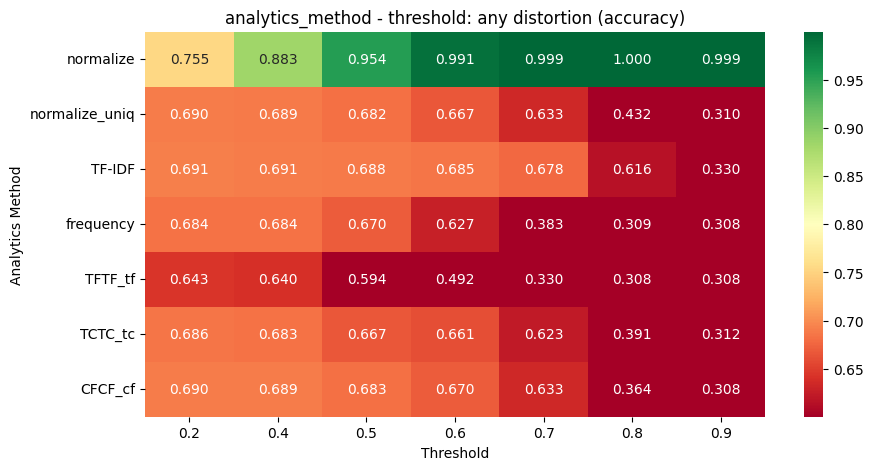

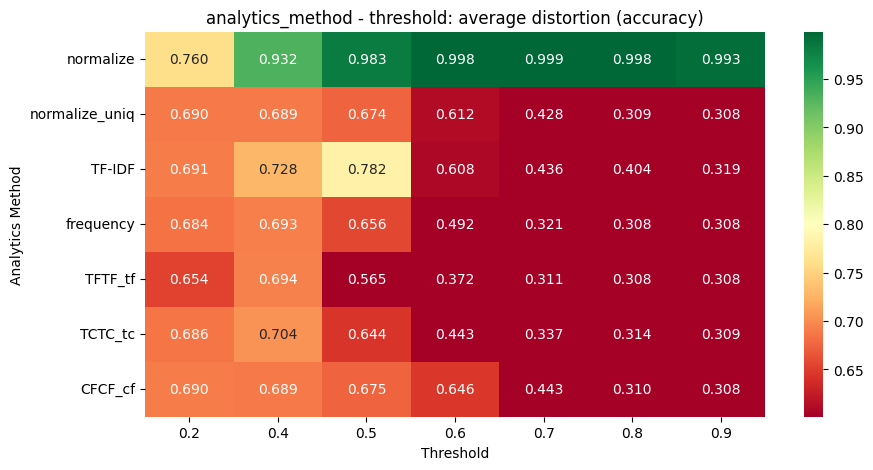

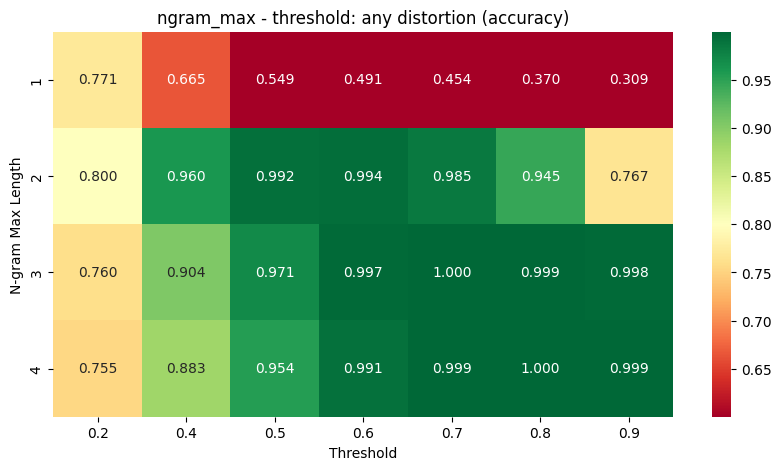

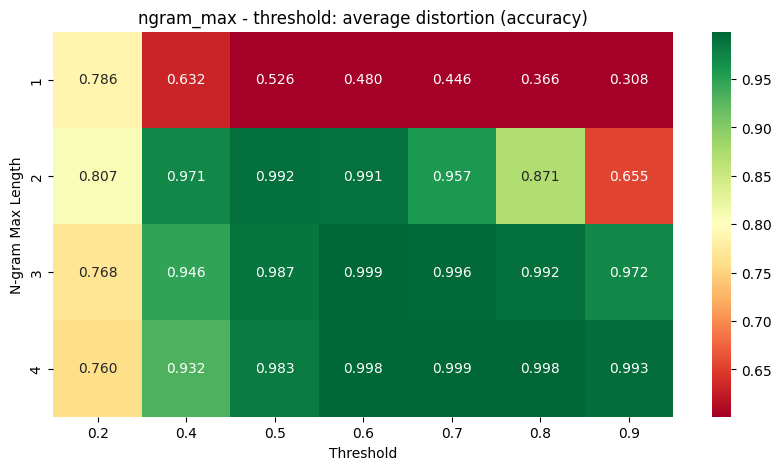

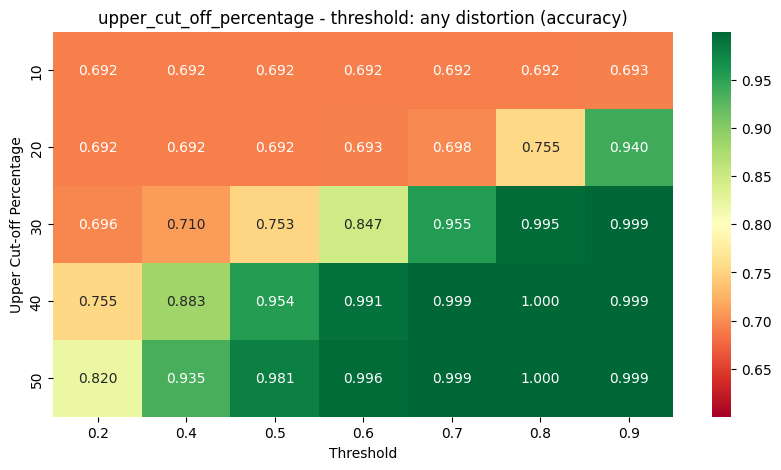

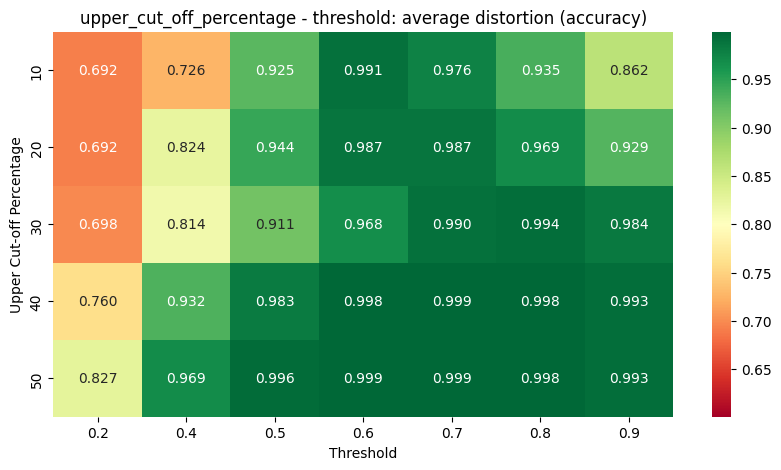

In [91]:
analytics_methods = ['normalize', 'normalize_uniq', 'TF-IDF', 'frequency', 'TFTF_tf', 'TCTC_tc', 'CFCF_cf']
thresholds = [0.2, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
ngram_max_values = [1, 2, 3, 4]
upper_cut_off_values = [10, 20, 30, 40, 50]

# 1) analytics_method - threshold
acc_analytics_threshold_any = np.zeros((len(analytics_methods), len(thresholds)))
acc_analytics_threshold_avg = np.zeros((len(analytics_methods), len(thresholds)))

for i, analytics_method in enumerate(analytics_methods):
    acc_data_any, acc_data_avg = analyse_dataset(analytics_method, 4, 40, df3, 'plot_results')
    for j, threshold in enumerate(thresholds):
        acc_analytics_threshold_any[i, j] = acc_data_any[threshold]
        acc_analytics_threshold_avg[i, j] = acc_data_avg[threshold]

plot_heatmap(acc_analytics_threshold_any, thresholds, analytics_methods,
             "analytics_method - threshold: any distortion (accuracy)",
             "Threshold", "Analytics Method")

plot_heatmap(acc_analytics_threshold_avg, thresholds, analytics_methods,
             "analytics_method - threshold: average distortion (accuracy)",
             "Threshold", "Analytics Method")


# 2) ngram_max - threshold
acc_ngrammax_threshold_any = np.zeros((len(ngram_max_values), len(thresholds)))
acc_ngrammax_threshold_avg = np.zeros((len(ngram_max_values), len(thresholds)))

for i, ngram_max in enumerate(ngram_max_values):
    acc_data_any, acc_data_avg = analyse_dataset('normalize', ngram_max, 40, df3, 'plot_results')
    for j, threshold in enumerate(thresholds):
        acc_ngrammax_threshold_any[i, j] = acc_data_any[threshold]
        acc_ngrammax_threshold_avg[i, j] = acc_data_avg[threshold]

plot_heatmap(acc_ngrammax_threshold_any, thresholds, ngram_max_values,
             "ngram_max - threshold: any distortion (accuracy)",
             "Threshold", "N-gram Max Length")

plot_heatmap(acc_ngrammax_threshold_avg, thresholds, ngram_max_values,
             "ngram_max - threshold: average distortion (accuracy)",
             "Threshold", "N-gram Max Length")


# 3) upper_cut_off_percentage - threshold
acc_upper_cut_off_threshold_any = np.zeros((len(upper_cut_off_values), len(thresholds)))
acc_upper_cut_off_threshold_avg = np.zeros((len(upper_cut_off_values), len(thresholds)))

for i, upper_cut_off_percentage in enumerate(upper_cut_off_values):
    acc_data_any, acc_data_avg = analyse_dataset('normalize', 4, upper_cut_off_percentage, df3, 'plot_results')
    for j, threshold in enumerate(thresholds):
        acc_upper_cut_off_threshold_any[i, j] = acc_data_any[threshold]
        acc_upper_cut_off_threshold_avg[i, j] = acc_data_avg[threshold]

plot_heatmap(acc_upper_cut_off_threshold_any, thresholds, upper_cut_off_values,
             "upper_cut_off_percentage - threshold: any distortion (accuracy)",
             "Threshold", "Upper Cut-off Percentage")

plot_heatmap(acc_upper_cut_off_threshold_avg, thresholds, upper_cut_off_values,
             "upper_cut_off_percentage - threshold: average distortion (accuracy)",
             "Threshold", "Upper Cut-off Percentage")

In [92]:
grand_t1 = dt.datetime.now()
grand_delta = grand_t1 - grand_t0
str(grand_delta)

'6:08:33.459532'